In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os
import glob as gb
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout
from zipfile import ZipFile
import matplotlib.image as mpimg
import warnings

sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

In [13]:
# import train and test data
trainDataPath = "C:/Users/Shahid Sanghar/Desktop/Dataset/dogs-vs-cats/train.zip"
testDataPath = "C:/Users/Shahid Sanghar/Desktop/Dataset/dogs-vs-cats/test1.zip"
ZipFile(trainDataPath,mode = "r").extractall()
ZipFile(testDataPath,mode =  "r").extractall()

In [14]:
train_path = "./train"
test_path = "./test1"

In [15]:
filenames = os.listdir(train_path)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(category)
    else:
        categories.append(category)

df = pd.DataFrame({
    'Image': filenames,
    'Category': categories})
df.head(-5)

,Image,Category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat
...,...,...
24990,dog.9990.jpg,dog
24991,dog.9991.jpg,dog
24992,dog.9992.jpg,dog
24993,dog.9993.jpg,dog


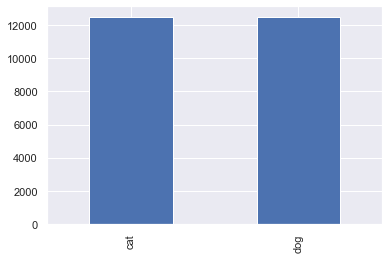

In [16]:
df['Category'].value_counts().plot.bar()

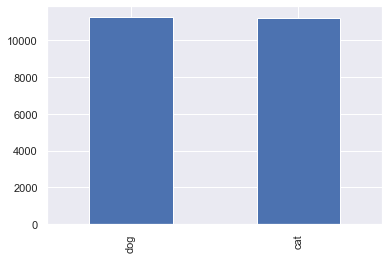

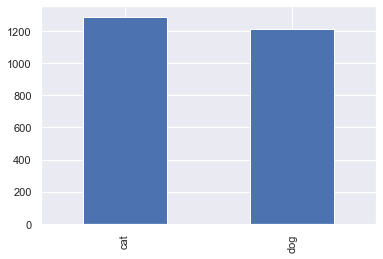

In [17]:
df_train, df_validation = train_test_split(df, test_size=0.1, random_state=18)
df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_train['Category'].value_counts().plot.bar()
plt.show()
df_validation['Category'].value_counts().plot.bar()

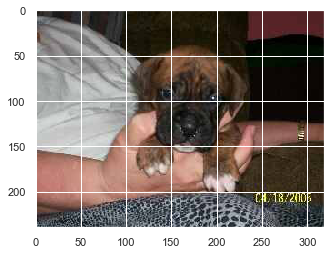

In [18]:
sample = random.choice(df['Image'])
plt.imshow(plt.imread(("./train/"+sample)))

In [19]:
size  = 150
channels = 3
batch = 128
epochs = 50

In [20]:
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             width_shift_range=.2, height_shift_range=.2,
                             rotation_range=30,
                             brightness_range=[0.8, 1.2],
                             horizontal_flip=True)

datagenValidation = ImageDataGenerator(rescale=1./255)

In [21]:
X_train = datagen.flow_from_dataframe(
    df_train, 
    directory = train_path, 
    x_col = 'Image',
    y_col = 'Category',
    target_size= (size,size),
    class_mode = 'binary',
    shuffle = True,
    batch_size = batch)

X_validation = datagenValidation.flow_from_dataframe(
    df_validation, 
    directory = train_path, 
    x_col = 'Image',
    y_col = 'Category',
    target_size= (size,size),
    class_mode = 'binary',
    shuffle = True,
    batch_size = batch)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


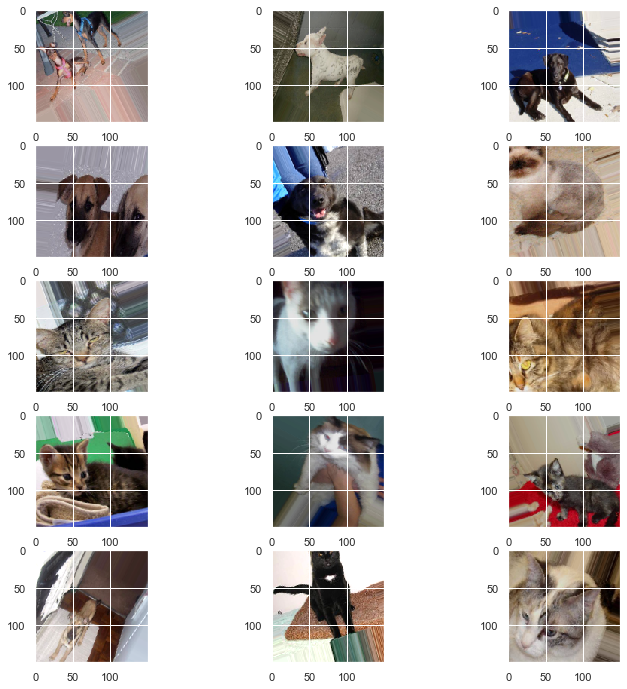

In [22]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in X_train:
        image = X_batch[0]
        plt.imshow(image)
        break
# plt.tight_layout()
plt.show()

In [23]:
checkpoint_filepath = 'best_model.hdf5'

callback_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callback_learningrate = ReduceLROnPlateau(monitor='val_accuracy', mode='max', min_delta=0.03, patience=3, factor=.5, min_lr=0.00001, verbose=1)

callbacks = [callback_checkpoint, callback_learningrate]

In [24]:
Model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(size,size,channels)),
                    BatchNormalization(),
                    MaxPool2D(2,2),
                    Dropout(0.2),
                 
                    Conv2D(filters=64,  kernel_size=(5,5), activation="relu"),
                    BatchNormalization(),
                    MaxPool2D(3,3),
                    Dropout(0.2),
                
                    Conv2D(filters=128, kernel_size=(7,7), activation="relu"),
                    BatchNormalization(),
                    MaxPool2D(4,4),
                    Dropout(0.2),
                 
                    Flatten(),
                    
                    Dense(units=4096, activation="relu"),                 
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(units=1024, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    
                                        
                    Dense(units=2, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.5),
                    
                    Dense(units=1, activation="sigmoid"),
])


Model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 70, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 70, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0

In [25]:
history = Model.fit(X_train, validation_data=X_validation, epochs=15, callbacks=callbacks)


Epoch 1/15
176/176 [==============================] - 742s 4s/step - loss: 0.7295 - accuracy: 0.5679 - val_loss: 0.6830 - val_accuracy: 0.5492
Epoch 2/15
176/176 [==============================] - 710s 4s/step - loss: 0.6760 - accuracy: 0.5992 - val_loss: 0.6478 - val_accuracy: 0.6496
Epoch 3/15
176/176 [==============================] - 690s 4s/step - loss: 0.6375 - accuracy: 0.6362 - val_loss: 0.6536 - val_accuracy: 0.6408
Epoch 4/15
176/176 [==============================] - 689s 4s/step - loss: 0.6024 - accuracy: 0.6624 - val_loss: 0.5767 - val_accuracy: 0.6788
Epoch 5/15
176/176 [==============================] - 691s 4s/step - loss: 0.5826 - accuracy: 0.6804 - val_loss: 0.5064 - val_accuracy: 0.7680
Epoch 6/15
176/176 [==============================] - 695s 4s/step - loss: 0.5597 - accuracy: 0.6929 - val_loss: 0.5468 - val_accuracy: 0.7108
Epoch 7/15
176/176 [==============================] - 668s 4s/step - loss: 0.5332 - accuracy: 0.7072 - val_loss: 0.4786 - val_accuracy: 0.7636

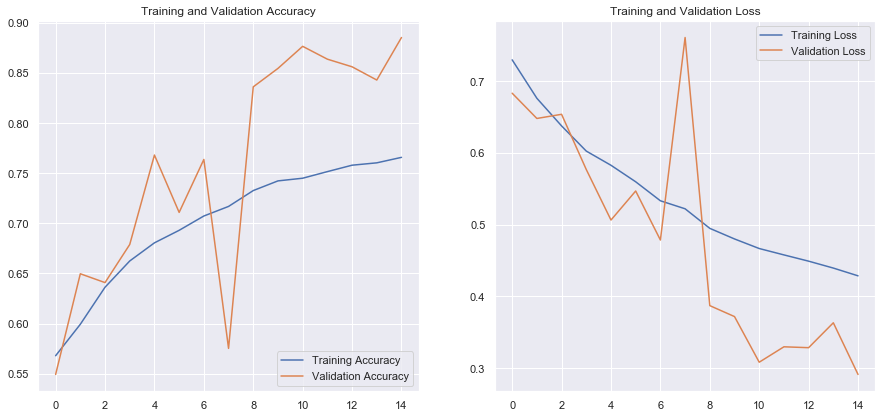

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
Model = tf.keras.models.load_model('best_model.hdf5')

In [29]:
filenames = os.listdir(test_path)
df_test = pd.DataFrame({'Image':filenames})

df_test.head(-5)

,Image
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg
...,...
12490,9990.jpg
12491,9991.jpg
12492,9992.jpg
12493,9993.jpg


In [30]:
X_test = datagenValidation.flow_from_dataframe(
    df_test, 
    directory=test_path, 
    x_col='Image',
    y_col=None,
    class_mode=None,
    target_size= (size,size),
    batch_size=batch,
    shuffle=False
)


Found 12500 validated image filenames.


In [31]:
X_train.class_indices

{'cat': 0, 'dog': 1}

In [32]:
y_pred = Model.predict(X_test)

In [33]:
y_pred = np.where(y_pred > .5, "Dog", "Cat")
y_pred

array([['Dog'],
       ['Cat'],
       ['Cat'],
       ...,
       ['Dog'],
       ['Cat'],
       ['Cat']], dtype='<U3')

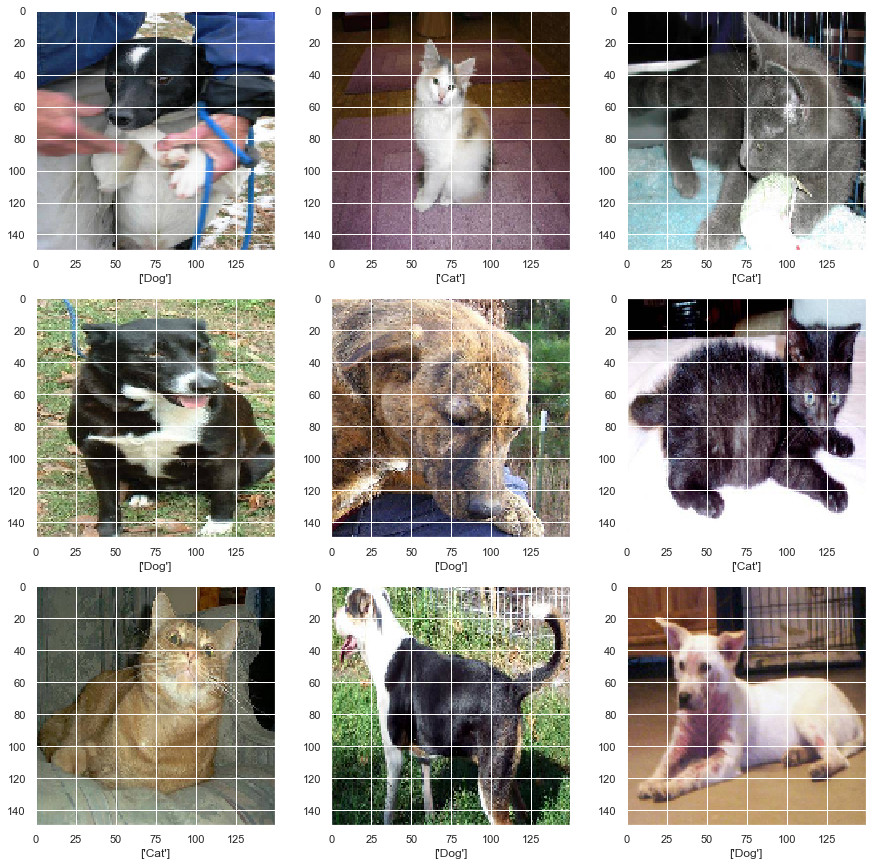

In [34]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[0][i])
    plt.xlabel(y_pred[i])
    
plt.show()

In [35]:
label = np.where(y_pred=="Cat", 0, 1)
label

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [37]:
df_submission = pd.read_csv('C:/Users/Shahid Sanghar/Desktop/Dataset/dogs-vs-cats/sampleSubmission.csv')
df_submission['label'] = label
df_submission.head(-5)

,id,label
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1
...,...,...
12490,12491,0
12491,12492,1
12492,12493,1
12493,12494,0


In [38]:
df_submission.to_csv('submission.csv', index=False)

In [39]:
submission = pd.read_csv('./submission.csv')
submission.head(-5)

,id,label
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1
...,...,...
12490,12491,0
12491,12492,1
12492,12493,1
12493,12494,0


In [56]:
file_path='C:/Users/Shahid Sanghar/Desktop/Dataset/dogs-vs-cats'
#Create a pickle file
import pickle
pickle_out = open(file_path + "/Model.pkl","wb")
pickle.dump(Model, pickle_out)
pickle_out.close()

TypeError: can't pickle weakref objects